<a href="https://colab.research.google.com/github/YAYAYru/ml_epenthesis/blob/main/Example1_external_Drive_and_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How get external Drive folder and training run with Neptune.ai

## How get "Shared with me" Drive folder?
- [1757 skeletal models with 30 FPS from the video words and sentenses](https://drive.google.com/drive/folders/128a7OL_0IsndoZhagx4_T7pkNuOR-0M8?usp=sharing) 
- [1757 weakly labeled movements with 30 FPS
 from the video words and sentenses](https://drive.google.com/drive/folders/13lgb-JGdpnZ8gEFGdYqiUAgcQN5Yp2zP?usp=sharing)

After receiving the link(above) to a not my Drive folder, click on "Share with me"->"Add a shortcut to Drive" and add shortcut to your Drive folder (ex. name folder "sl_dataset") further below. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check and determine сount of the files of skelet models and weakly labeled movements

In [ ]:
path_folder_csv = "drive/MyDrive/sl_dataset/csv_slsru_skelet_v0_1_0/x_x_cx_and_sxx_interpol_30FPS/"
path_folder_json = "drive/MyDrive/sl_dataset/WeaklyLabeledMovement/x_x_cx_and_sxx_interpol_30FPS/"
import glob
list_csv = glob.glob(path_folder_csv + "*")
list_json = glob.glob(path_folder_json + "*")
print("len(list_csv)", len(list_csv))
print("len(list_json)", len(list_json))


len(list_csv) 1757
len(list_json) 1757


## Get custom import source from GitHub repo


In [ ]:
#!rm -rf ml_epenthesis
!cd ml_epenthesis && git pull
#!git clone https://github.com/YAYAYru/ml_epenthesis

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/YAYAYru/ml_epenthesis
   8d20c71..4d8eff7  main       -> origin/main
Updating 8d20c71..4d8eff7
Fast-forward
 code/learn.py | 36 ------------------------------------
 1 file changed, 36 deletions(-)


In [ ]:
#!pip install neptune-client neptune-tensorflow-keras tensorflow

## Load from csv and json files to general merging training data

In [ ]:
#https://colab.research.google.com/github/jckantor/cbe61622/blob/master/docs/A.02-Downloading_Python_source_files_from_github.ipynb#scrollTo=4LgzwY2VVmEm
import sys
repo = "ml_epenthesis"
src_dir = "code"

sys.path.insert(1, f"{repo}/{src_dir}")
import load
import trans
import config
import learn
import inference

### If rename paramer `mode="fast"` to `mode=""` then will load from all files wait a few minute else fast load from one file only

In [ ]:
x_full, y_full = load.from_json_csv_by_folders(path_folder_csv, path_folder_json, mode="fast")

-- from_json_csv_by_folders()
len(pathcsv_list): 1757
len(pathjson_list): 1757
set csv and json 1757
set csv ^ json 0
set csv - json 0
set json - csv 0
videolist.shape (1757,)
n 1000095_5_1.mp4
X.shape (244, 50)
Y.shape (244,)


## Convert coordinate points of skelet model to angles between points
Run only once

In [ ]:
x_full = trans.tranform_angles(x_full)

tranform_angles(features).shape (244, 4)


## Convert general merging training data to windowing data on frame rate series data

In [ ]:
x_steps, y_steps = trans.windowing_xy(x_full, y_full, config.WINDOW_SIZE, y_last_or_center="center")  

step_x.shape (214, 31, 4)
step_y.shape (214,)
np.unique(step_y [0 1 3 4]
Counter(y_full) Counter({0: 150, 4: 44, 1: 26, 3: 24})


## Check imbalancing classes

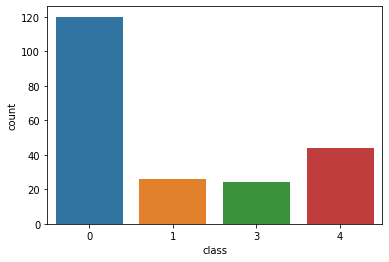

In [ ]:
import seaborn as sns
import pandas as pd
df_y_full = pd.DataFrame(data=y_steps, columns=["class"])
sns.countplot(x="class", data=df_y_full )

## Reduce training data to balancing classes



x (96, 31, 4)
y (96,)
Counter(y) Counter({0: 24, 1: 24, 3: 24, 4: 24})
min_key 0
min_value 24
labelnp [0 1 3 4]
counter_Y Counter({0: 24, 1: 24, 3: 24, 4: 24})


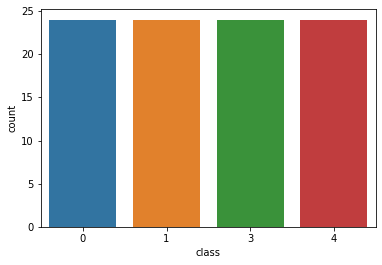

In [ ]:
x_steps, y_steps = trans.inbalance2balance_postwindow(x_steps,y_steps)
df_y_steps = pd.DataFrame(data=y_steps, columns=["class"])
sns.countplot(x="class", data=df_y_steps )

## Split training and validation data

In [ ]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = learn.split_train_val_test(x_steps, y_steps, config.TEST_SIZE)

## Y to categotical

In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [ ]:
Y_train_one = tf.keras.utils.to_categorical(Y_train)
Y_val_one = tf.keras.utils.to_categorical(Y_val)
Y_test_one = tf.keras.utils.to_categorical(Y_test)

In [ ]:
model = learn.model_fn(X_val.shape, Y_val_one.shape)

def model_fn(x_shape, y_shape)
x_shape (10, 31, 4)
y_shape (10, 5)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 31, 512)           1058816   
                                                                 
 lstm_1 (LSTM)               (None, 31, 128)           328192    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                       

In [ ]:
history = model.fit(X_train, Y_train_one, epochs=10, verbose=2,
        batch_size=config.BATCH_SIZE, validation_data = (X_val, Y_val_one))

Epoch 1/10
1/1 - 1s - loss: 1.6033 - accuracy: 0.6053 - val_loss: 1.6003 - val_accuracy: 0.7000 - 606ms/epoch - 606ms/step
Epoch 2/10
1/1 - 1s - loss: 1.6027 - accuracy: 0.6053 - val_loss: 1.5996 - val_accuracy: 0.7000 - 601ms/epoch - 601ms/step
Epoch 3/10
1/1 - 1s - loss: 1.6022 - accuracy: 0.6053 - val_loss: 1.5988 - val_accuracy: 0.7000 - 625ms/epoch - 625ms/step
Epoch 4/10
1/1 - 1s - loss: 1.6017 - accuracy: 0.6053 - val_loss: 1.5980 - val_accuracy: 0.7000 - 592ms/epoch - 592ms/step
Epoch 5/10
1/1 - 1s - loss: 1.6011 - accuracy: 0.6053 - val_loss: 1.5972 - val_accuracy: 0.7000 - 608ms/epoch - 608ms/step
Epoch 6/10
1/1 - 1s - loss: 1.6005 - accuracy: 0.5921 - val_loss: 1.5963 - val_accuracy: 0.7000 - 593ms/epoch - 593ms/step
Epoch 7/10
1/1 - 1s - loss: 1.5998 - accuracy: 0.5921 - val_loss: 1.5954 - val_accuracy: 0.7000 - 602ms/epoch - 602ms/step
Epoch 8/10
1/1 - 1s - loss: 1.5991 - accuracy: 0.5789 - val_loss: 1.5944 - val_accuracy: 0.7000 - 610ms/epoch - 610ms/step
Epoch 9/10
1/1 -

## Save model

In [ ]:
name_model = "test"
path_model_write = "model/" + name_model
tf.saved_model.save(model, path_model_write + "_tf")
model.save(path_model_write + "_keras.h5")
model.save(path_model_write +"_tfv2", save_format="tf")

INFO:tensorflow:Assets written to: model/test_tf/assets


INFO:tensorflow:Assets written to: model/test_tf/assets


INFO:tensorflow:Assets written to: model/test_tfv2/assets


INFO:tensorflow:Assets written to: model/test_tfv2/assets


## Read model

In [ ]:
#Y_pred_one = model.predict(X_test, verbose=2)
path_model_read = "model/" + name_model + "_tfv2"
saved_model = tf.keras.models.load_model(path_model_read)

# Check model

In [ ]:
import numpy as np

print("Y_pred_one[0:10]", Y_pred_one[0:10])
Y_pred = []
for p in Y_pred_one:
  #Y_pred.append(np.round(p[0]))
  Y_pred.append(np.argmax(p))
print("len(Y_pred)", len(Y_pred))
print("Y_pred[0:10]", Y_pred)
print("Y_test[0:10]", Y_test.tolist())

Y_pred_one[0:10] [[0.19980866 0.20361261 0.19821715 0.19545843 0.20290317]
 [0.20380706 0.19859648 0.19899058 0.19814715 0.20045874]
 [0.19985929 0.20487554 0.1977634  0.19507308 0.20242864]
 [0.19957425 0.2041963  0.19812466 0.1951261  0.20297869]
 [0.2045123  0.1975514  0.19928795 0.19867244 0.19997586]
 [0.19973068 0.20380108 0.1981892  0.19534928 0.2029298 ]
 [0.1991509  0.20620714 0.19757105 0.19415526 0.20291561]
 [0.19923909 0.20535739 0.19785301 0.19448304 0.20306744]
 [0.20358904 0.1982703  0.19904006 0.19862512 0.20047548]
 [0.20450345 0.19755702 0.1992851  0.19867225 0.19998217]]
len(Y_pred) 10
Y_pred[0:10] [1, 0, 1, 1, 0, 1, 1, 1, 0, 0]
Y_test[0:10] [4, 0, 1, 4, 0, 4, 1, 4, 3, 0]


## Evalution model

In [ ]:
eval_metrics = model.evaluate(X_test, Y_test_one)
print("test/loss", eval_metrics[0])
print("test/acc", eval_metrics[1])

1/1 [==============================] - 0s 45ms/step - loss: 1.5924 - accuracy: 0.5000
test/loss 1.592423439025879
test/acc 0.5


## Confusion matrix
0 - Idle  
1 - Begin movement  
2 - Transitional movement(epenthesis)  
3 - End movement  
4 - Sign(gloss)

ml_epenthesis/code/inference.py:45: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [nan nan nan nan nan]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]]


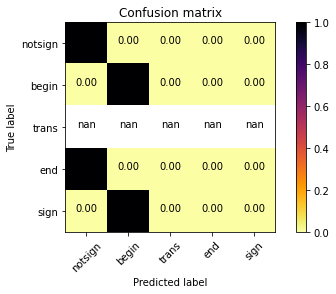

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred, labels=[0,1,2,3,4])
cnf_matrix = inference.plot_confusion_matrix(cnf_matrix, ["notsign","begin","trans","end","sign"])

0 - Idle  
1 - Begin movement  
2 - Transitional movement(epenthesis)  
3 - End movement  
4 - Sign(gloss)  